### Libraries:

In [11]:
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
import random
from random import randrange
import matplotlib.pyplot as plt

### Functions:

In [2]:
def date_list(lst, n):
        '''
        Slice list into n sublists, sort them, merge again and return a single list
        '''
        sublists = [lst[i:i + n] for i in range(0, len(lst), n)]
        sublists = [sorted([datetime.strptime(date, '%d/%m/%Y').date()
                           for date in sublist]) for sublist in sublists]
        sorted_list = [str(date.strftime('%d/%m/%Y'))
                       for sublist in sublists for date in sublist]
        return sorted_list
    
    
def random_date(start, end):
        '''
        This function will return a random datetime between two datetime 
        objects.
        '''
        delta = end - start
        int_delta = (delta.days * 24 * 60 * 60)  # + delta.seconds
        random_second = randrange(int_delta)
        return start + timedelta(seconds=random_second)

In [3]:
def create_test_data(price_5_percentile, 
                     price_95_percentile, 
                     quantity_5_percentile, 
                     quantity_95_percentile, 
                     n_products,
                     n_transactions,
                     n_customers,
                     elasticity,
                     start_date,
                     end_date
                                        ):
    
    '''
    - `price_5_percentile`: 5% percentile of prices in the training data.
    - `price_95_percentile`: 95% percentile of prices in the training data.
    - `quantity_5_percentile`: 5% percentile of quantities in the training data.
    - `quantity_95_percentile`: 95% percentile of quantities in the training data.
    - `n_products`: Number of products in the test data.
    - `n_transactions`: Number of transactions for each product in the test data.
    - `n_customers`: Number of customers in the test data.
    - `elasticity`: A list of elasticity values to test with each product.
    - `start_date`: Start date for transaction date generation.
    - `end_date`: End date for transaction date generation.
    '''
    
    price_growth = price_95_percentile/price_5_percentile
    
    # we want to show prices in dynamic to reflect changes in demand according to predefined elasticity 
    # we want products to differ, for this we need unique start price for each product 
    # multiplicator is needed to grow price from 0.5 percentile to 0.95 percentile in n steps (n = n_products)
    #each step will help to define the start price for each next product
    p_step = price_growth**(1 / n_products)
    
    #creating start prices list
    p = [p_05]
    p = [p[0] * p_step ** i for i in range(n_products)]
    
    # removing last price to avoid testing prices higher than 0.95 percentile
    p = np.round(p)[:-1]
    
    #we will use the same logic to get start quantities list
    quantity_growth = q_95 / q_05
    q_step = quantity_growth**(1 / n_products)
    q = [q_05]
    q = [q[0] * q_step ** i for i in range(n_products)]
    q = np.round(q)[:-1]
    q = [i for i in q.tolist() if i < q_95]
    q = sorted(q, reverse=True)
    
    df = pd.DataFrame()

    for e in elasticity:
        for n in range(n_products - 1):
            #calculating what price change should be used as a step for each transaction
            pct_q = ((q_95 / q[n])**(1 / (n_transactions - 1)) - 1) / 2
            pct_p = ((p_95 / p[n])**(1 / (n_transactions - 1))) - 1
            pct = min(pct_q, pct_p)
            
            df_prod = pd.DataFrame(index=range(n_transactions))
            df_prod[column_namings['prod_name_col']] = f'Product_{n+1}'
            df_prod[column_namings['elasticity_col']] = e
            
            # creating pairs quantity-price for n products
            sales = [[p[n] * (1 + pct)**i, q[n] * (1 + pct * e)**i]
                         for i
                         in range(n_transactions)
                         ]
            
            pq = pd.DataFrame(sales, 
                              columns=[column_namings['price_col'], 
                                       column_namings['quantity_col']])
            
            df_prod = df_prod.join(pq)
            df = pd.concat([df, df_prod])
        df = df.reset_index(drop=True)
        
        # adding revenue column
        df[column_namings['revenue_col']] = df[column_namings['quantity_col']] * df[column_namings['price_col']]
        
    # adding customer columns
    #customer will be picked randomly for each transaction
    customer_list = [f'Tester_{i}' for i in range(n_customers)]
    list_of_customers = [random.choice(customer_list) for _ in range(len(df))]
    df[column_namings['customer_col']] = list_of_customers
    
    # adding date column
    #dates are being choosed randomly in range from start_date to end_date with reasonable step

    d1 = datetime.strptime(start_date, '%d/%m/%Y')
    d2 = datetime.strptime(end_date, '%d/%m/%Y')
    
    dates_list = []
    dates_list = [random_date(d1, d2).strftime('%d/%m/%Y') 
                  for _ 
                  in range((n_products -1) * 
                        n_transactions * 
                        len(elasticity))]
    dates_list = date_list(dates_list, n_transactions)
    df[column_namings['date_col']] = dates_list
    df[column_namings['date_col']]  = pd.to_datetime(df[column_namings['date_col']] , format='%d/%m/%Y')
    
    df[column_namings['year_col']] = df[column_namings['date_col']].dt.year

    #if quantity is calculated below 0, we want to replace it with 1
    df.loc[df[column_namings['quantity_col']] <
               1, column_namings['quantity_col']] = 1
    
    result = pd.DataFrame()
    #in case we want to test impact of country or currency column on prediction
    #so need to add different brands
    for d in data_brands:
        for k, v in d.items():
            df[k] = v
        result = pd.concat([result, df])
            
    result = result.reset_index(drop=True)

    return result
    

### Dictionaries:

In [4]:
column_namings = {'price_col': 'Price',
                 'prod_name_col': 'Product',
                 'elasticity_col':'Elasticity',
                 'quantity_col': 'Quantity',
                 'revenue_col': 'Total',
                 'customer_col': 'Customer',
                 'date_col': 'Date',
                 'year_col': 'Year'}

### Inputs:

Define percentiles:
* p_05 = train_data['Price'].quantile(0.05)
* p_95 = train_data['Price'].quantile(0.95) <br/> <br/>
* q_05 = train_data['Quantity'].quantile(0.05)
* q_95 = train_data['Quantity'].quantile(0.95)

In [5]:
p_05 = 24      # 5% percentile of prices in train data
p_95 = 7500    # 95% percentile of prices in train data

q_05 = 1       # 5% percentile of quantities in train data
q_95 = 200     # 95% percentile of quantities in train data

p_n = 10       # number of products in test data
t_n = 100      # number of transactions for each product in test data
c_n = 45       # number of customers in test data

e = [-1, 0, 1] #list of elastisities to test with each product

In [6]:
data_brands = [
            {'Brand': 'Air Defence Show',
             'Currency': 'UAH',
             'Brand country': 'Ukraine',
             'Brand market': 'Public admin, defence & social security',
             },

            {'Brand': 'Best Tanks Show',
             'Currency': 'USD',
             'Brand country': 'USA',
             'Brand market': 'Public admin, defence & social security',
             }
]


### Results:

In [7]:
test_data = create_test_data(p_05, p_95, q_05, q_95, p_n, t_n, c_n, e, '1/1/2014','1/1/2022' )

In [8]:
test_data.sample(5)

,Product,Elasticity,Price,Quantity,Total,Customer,Date,Year,Brand,Currency,Brand country,Brand market
4632,Product_2,1,55.609026,53.022559,2948.532869,Tester_35,2016-07-20,2016,Best Tanks Show,USD,USA,"Public admin, defence & social security"
2845,Product_2,-1,61.732519,28.475155,1757.843051,Tester_27,2017-05-23,2017,Best Tanks Show,USD,USA,"Public admin, defence & social security"
580,Product_6,-1,1908.500479,1.079251,2059.751007,Tester_21,2020-05-04,2020,Air Defence Show,UAH,Ukraine,"Public admin, defence & social security"
2421,Product_7,1,1182.680953,4.705627,5565.255579,Tester_11,2015-12-16,2015,Air Defence Show,UAH,Ukraine,"Public admin, defence & social security"
1652,Product_8,0,3308.741654,2.000000,6617.483308,Tester_36,2019-02-10,2019,Air Defence Show,UAH,Ukraine,"Public admin, defence & social security"


The calculated trend for both price and quantity, considering different elasticities, helps verify the accuracy of data generation. Zero elasticity implies that there is no change in quantity, indicating that customers do not respond to price fluctuations. A -1 elasticity signifies a decrease in demand when prices rise, while a 1 elasticity indicates that an increase in price leads to a higher demand – though this scenario may be not common, it is suitable for testing predictive models.


In [9]:
(test_data.groupby(['Brand', 
                    'Brand market',
                    'Brand country', 
                    'Currency',
                    'Product', 
                    'Elasticity'])[['Price', 'Quantity']].apply(
                                                                lambda x: x.pct_change()
                                                                           .mean())
                                                                           .reset_index()
                                                                           .fillna(0)
                                                                           .head(15))

,Brand,Brand market,Brand country,Currency,Product,Elasticity,Price,Quantity
0,Air Defence Show,"Public admin, defence & social security",Ukraine,UAH,Product_1,-1,0.005404,-0.005404
1,Air Defence Show,"Public admin, defence & social security",Ukraine,UAH,Product_1,0,0.005404,0.000000
2,Air Defence Show,"Public admin, defence & social security",Ukraine,UAH,Product_1,1,0.005404,0.005404
3,Air Defence Show,"Public admin, defence & social security",Ukraine,UAH,Product_2,-1,0.008068,-0.008068
4,Air Defence Show,"Public admin, defence & social security",Ukraine,UAH,Product_2,0,0.008068,0.000000
5,Air Defence Show,"Public admin, defence & social security",Ukraine,UAH,Product_2,1,0.008068,0.008068
6,Air Defence Show,"Public admin, defence & social security",Ukraine,UAH,Product_3,-1,0.010824,-0.010824
7,Air Defence Show,"Public admin, defence & social security",Ukraine,UAH,Product_3,0,0.010824,0.000000
8,Air Defence Show,"Public admin, defence & social security",Ukraine,UAH,Product_3,1,0.010824,0.010824
9,Air Defence Show,"Public admin, defence & social security",Ukraine,UAH,Product_4,-1,0.013613,-0.013613


The strength of this test dataset lies in its realistic distribution, which is crucial for conducting unbiased testing.

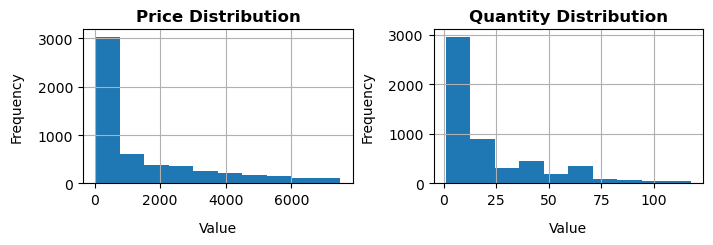

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 2))  
test_data[['Price', 'Quantity']].hist(ax=axes)

for ax in axes:
    ax.set_xlabel('Value', labelpad=10)
    ax.set_ylabel('Frequency', labelpad=10)
    
axes[0].set_title('Price Distribution', fontweight='bold')  # Bold title
axes[1].set_title('Quantity Distribution', fontweight='bold')  # Bold title

plt.show()